In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn 

## 1. Load data
* create a virtual data
* split data into training and test set
* virtualize the data

In [4]:
# Create *known* parameters
weight = 0.4
bias = 0.4

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1) # to use nn.Module need 1 dimension tensor
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4080],
         [0.4160],
         [0.4240],
         [0.4320],
         [0.4400],
         [0.4480],
         [0.4560],
         [0.4640],
         [0.4720]]))

In [9]:
# split data into train and test sets
train_split = int(len(X) * 0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
print(f'Train X, y: {len(X_train), len(y_train)}')
print(f'Test X, y: {len(X_test), len(y_test)}')



Train X, y: (40, 40)
Test X, y: (10, 10)


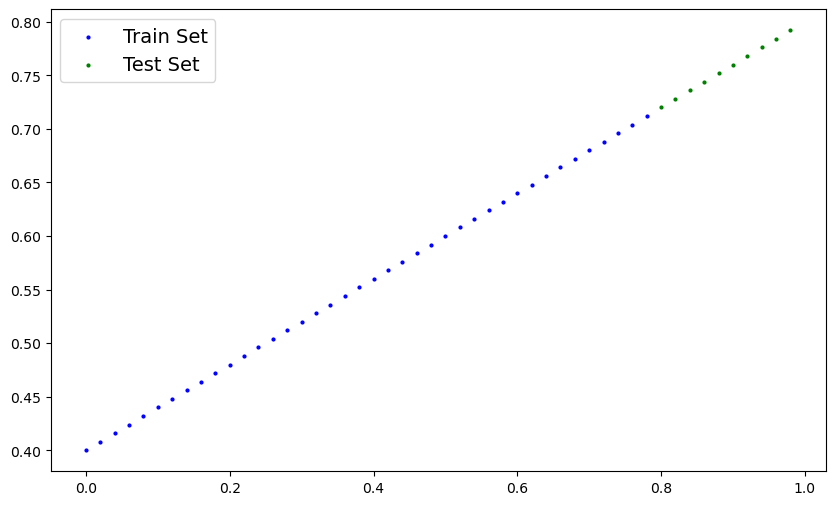

In [13]:
# virtualize data
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize=(10, 6))

    plt.scatter(train_data, train_labels, s = 4, c = 'b', label = 'Train Set')
    plt.scatter(test_data, test_labels, s = 4, c = 'g', label = 'Test Set')

    if predictions is not None: # plot predictions if it exits
        plt.scatter(test_data, predictions, s = 4, c = 'r', label = 'Predictions')
    
    # show legend
    plt.legend(prop = ({'size': 14}))
plot_predictions()

## 2. Create model 

In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float32),
                                    requires_grad= True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32),
                                 requires_grad= True)
    
    # forward function define computation in the model
    # required to be overwrite when using nn.Module
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return X * self.weight + self.bias
    


In [18]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model= LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model.parameters())

# List named parameters 
model.state_dict()


OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

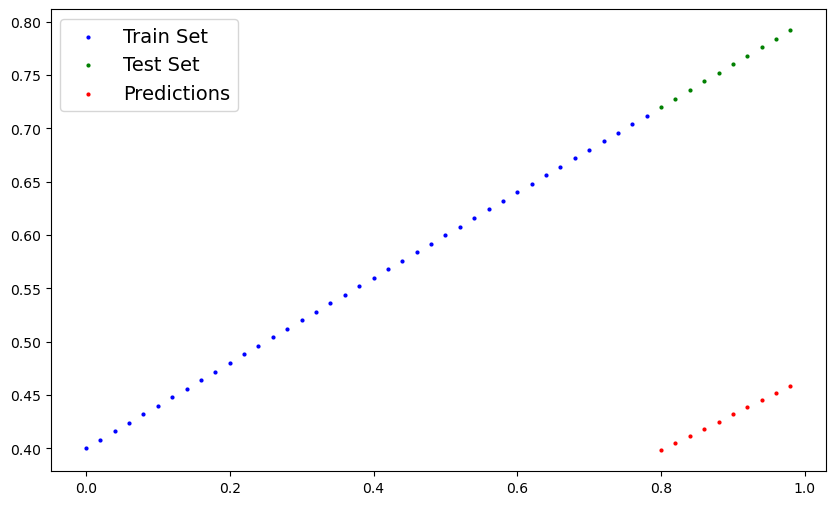

In [19]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model(X_test)

plot_predictions(predictions=y_preds)

### Train model

In [20]:
# choose loss function
loss_fn = nn.L1Loss()

# optizer
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.01)

In [21]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.29588136076927185 | MAE Test Loss: 0.314065158367157 
Epoch: 10 | MAE Train Loss: 0.1806713342666626 | MAE Test Loss: 0.1793552190065384 
Epoch: 20 | MAE Train Loss: 0.0654614195227623 | MAE Test Loss: 0.04464535787701607 
Epoch: 30 | MAE Train Loss: 0.005730757024139166 | MAE Test Loss: 0.012652510777115822 
Epoch: 40 | MAE Train Loss: 0.002291946206241846 | MAE Test Loss: 0.004379963967949152 
Epoch: 50 | MAE Train Loss: 0.0025127462577074766 | MAE Test Loss: 0.00813322700560093 
Epoch: 60 | MAE Train Loss: 0.0025127462577074766 | MAE Test Loss: 0.00813322700560093 
Epoch: 70 | MAE Train Loss: 0.0025127462577074766 | MAE Test Loss: 0.00813322700560093 
Epoch: 80 | MAE Train Loss: 0.0025127462577074766 | MAE Test Loss: 0.00813322700560093 
Epoch: 90 | MAE Train Loss: 0.0025127462577074766 | MAE Test Loss: 0.00813322700560093 


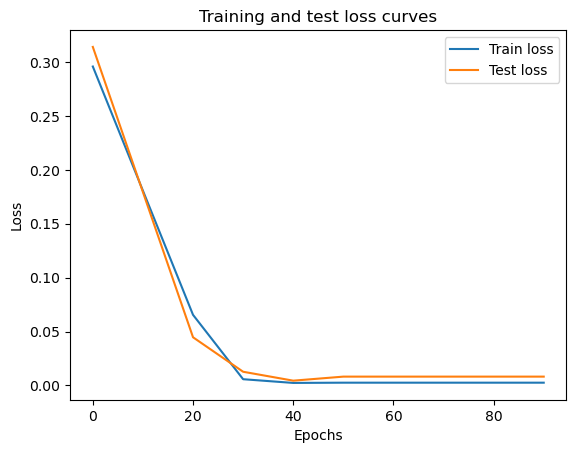

In [22]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [24]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.4057])), ('bias', tensor([0.4003]))])

And the original values for weights and bias are:
weights: 0.4, bias: 0.4


In [25]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_test)
y_preds

tensor([[0.7248],
        [0.7329],
        [0.7411],
        [0.7492],
        [0.7573],
        [0.7654],
        [0.7735],
        [0.7816],
        [0.7897],
        [0.7978]])

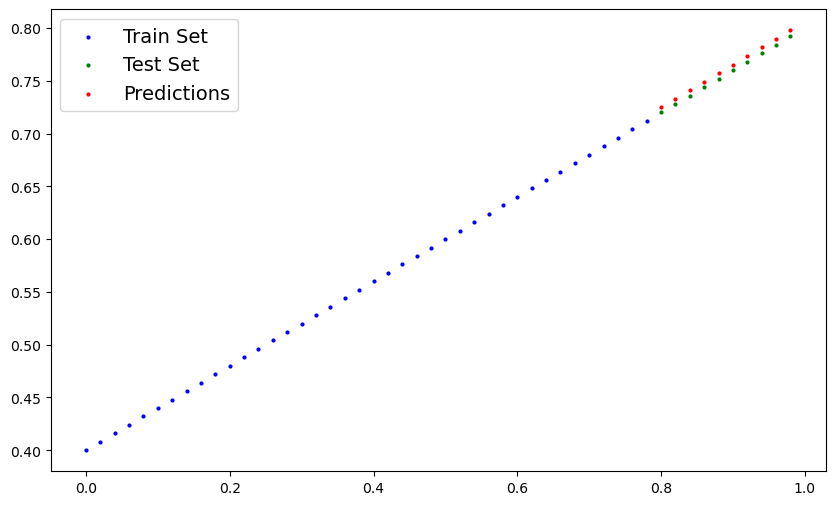

In [26]:
plot_predictions(predictions=y_preds)

### Save model

In [27]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


In [29]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 samith samith 1680 Feb 16 14:53 models/01_pytorch_workflow_model_0.pth


### Load model

In [30]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model


In [32]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])